Jupyter notebook that demonstrates how to download and use Cryotempo-EOLIS data, downloaded from cs2eo.org.

To run this notebook, you will need to make sure that the folllowing packages are installed in your python environment (all can be installed via pip/conda)

    - matplotlib
    - pandas: for dataframe manipulation
    - netCDF4: for handing NetCDF files
    - glob
    - datetime: for handling timestamps
    - numpy
    - geopandas: for creating geo-dataframes

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 

GRIDDED PRODUCT - DIGITAL ELEVATION MODEL

1) To Download Data:

- Cryotempo-EOLIS data is downloaded using cs2eo.org
- Paste the following url into your browser:
https://cs2eo.org/search?searchMode=single-polygon&productA=TEMPO_SWATH_GRID&polygon=[[-26.48,66.69],[-24.9,62.98],[-11.49,62.61],[-10.99,66.76],[-26.48,66.69]]&startDate=2021-10-01&startTime=00:00&endDate=2022-04-01&endTime=00:00&trackSpacing=100&batchRequest=false
- This will take you to a specific query of Iceland
- Click on the link to 'Download CryoSat-2 CryoTEMPO EOLIS Gridded Product data'
- This will download a python script that you should run in a terminal - it will download 6 months of gridded data for the Vatnajokull icecap to your current directory. It requires 552kB of space on your local drive.
- Once the data has downloaded, you can run the rest of the notebook:

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import netCDF4 as nc
import glob
import numpy as np
import matplotlib.dates as mdate
import geopandas
import datetime

/home/dubbersophie/.conda/envs/ew_eolis/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def get_gridded_data_from_nc(file_path):
    netcdf = nc.Dataset(file_path)
    time =  netcdf.variables['time']
    timestamp = time[:]
    data = {}
    dem, x_bnds, y_bnds = [], [], []
    for v in netcdf.variables:
        d = netcdf.variables[v]
        if len(d.shape) == 1:
            srs = pd.Series(d[:])
            data[v] = srs
        else:
            if v == 'elevation':
                dem.append(d[:])
            elif v == 'x_bnds':
                x_bnds.append(d[:])
            elif v == 'y_bnds':
                y_bnds.append(d[:])

    dem[0][dem[0].mask] = np.nan

    xs = np.average(x_bnds[0].data, axis=1)
    ys = np.average(y_bnds[0].data, axis=1)
    yy, xx = np.meshgrid(ys, xs)
    df = pd.DataFrame()
    df['x'] = xx.flatten()
    df['y'] = yy.flatten()
    df['elevation'] = dem[0].data.reshape(len(xs), len(ys)).flatten()
    netcdf.close()
    return df, timestamp

In [3]:
# Fill this filepath in with the location of the downloaded gridded data on your local system
data_filepath = '/data/ox1/working/cryotempo_investigations/eolis_demo/gridded_data/'
region_crs = '+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs' # Standard projection information for iceland
files = sorted(glob.glob(data_filepath+'/*.nc'))

In [4]:
dems, timestamp_list = [], []

for i in range(len(files)):
    df, timestamp = get_gridded_data_from_nc(files[i])
    timestamp_list.append(timestamp)
    gdf = geopandas.GeoDataFrame(df, crs=region_crs, geometry=geopandas.points_from_xy(df.x, df.y))
    dems.append(gdf)
    
dates = [datetime.datetime.fromtimestamp(a[0]) for a in timestamp_list]    

Text(1409.8970588235295, 0.5, 'y [m]')

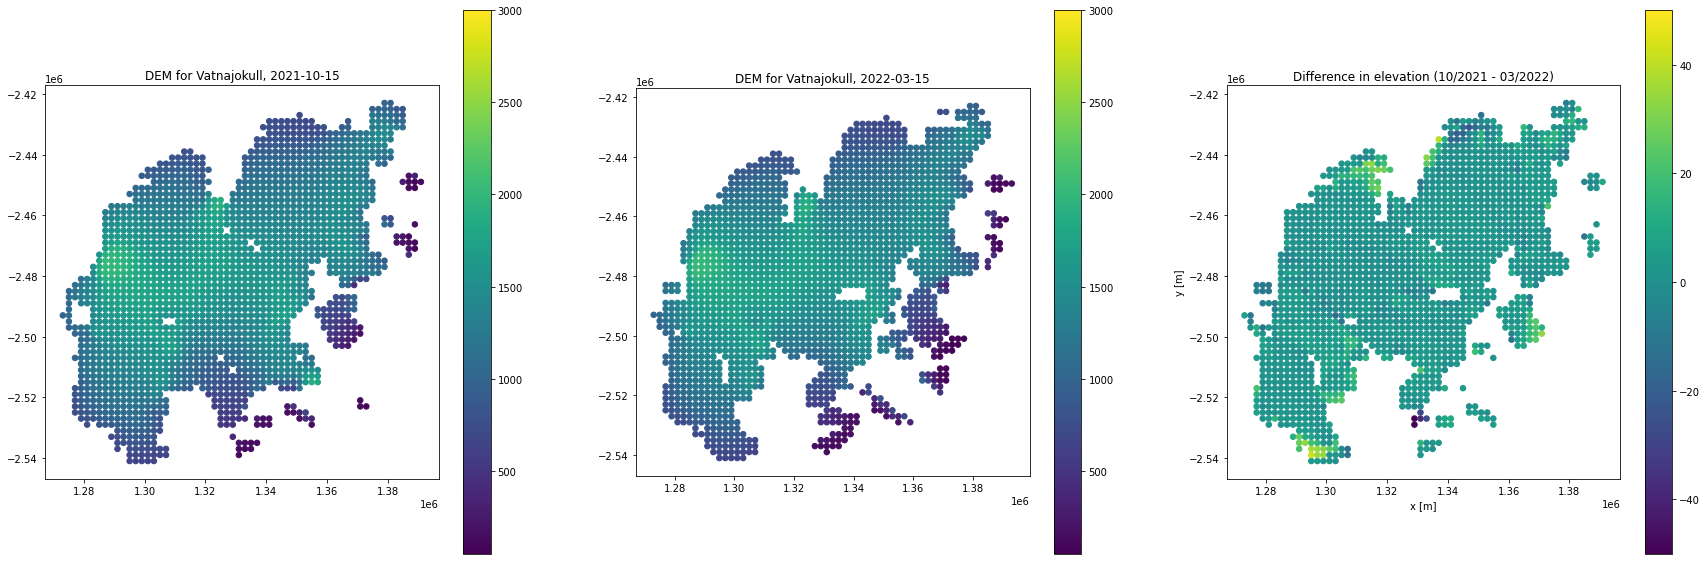

In [23]:

fig, axs = plt.subplots(1,3,figsize=(30, 10))
gdf1 = dems[0]
a = gdf.plot(ax=axs[0], column=gdf1['elevation'], markersize=30, cmap='viridis',vmin = 50,vmax = 3000, legend=True)
axs[0].set_title('DEM for Vatnajokull, '+str(dates[0].date()))
gdf2 = dems[-1]
b = gdf.plot(ax=axs[1], column=gdf2['elevation'], markersize=30, cmap='viridis',vmin = 50,vmax = 3000, legend=True)
axs[1].set_title('DEM for Vatnajokull, '+str(dates[-1].date()))

c = gdf.plot(ax=axs[2], column=gdf2['elevation']-gdf1['elevation'], markersize=30, cmap='viridis',vmin = -50,vmax = 50, legend=True)
axs[2].set_title('Difference in elevation (10/2021 - 03/2022)')

plt.xlabel('x [m]')
plt.ylabel('y [m]')
#plt.savefig(data_filepath+str(dates[i])+'_greenland_gridded_product.png')
